# Autocorrelation for Glauber dynamics on homogeneous tree

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Plots, Printf, Statistics, ProgressMeter
ProgressMeter.ijulia_behavior(:clear);

┌ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]
└ @ Base loading.jl:1662


In [162]:
function regular_tree_adjmat(k::Integer, z::Integer)
    N = Int((z^k-1)/(z-1))
    A = falses(N,N); i = 0
    for l in 1:k-1
        w = Int((z^(l-1)-1)/(z-1))
        x = w + z^(l-1)
        for j in 1:z^(l-1)
            i = w + j
            A[x+(j-1)*z+1:x+j*z, i] .= 1
        end        
    end
    A .⊻ A'
end
function regular_tree_fadjlist(k::Integer, z::Integer)
    n = Int((z^k-1)/(z-1))
    ne = n - 1
    T = typeof(k)
    fadjlist = Vector{Vector{T}}(undef, n)
   
    fadjlist[1] = 2:z+1
    
    for l in 2:k-1
        w = Int((z^(l-1)-1)/(z-1))
        x = w + z^(l-1)
        for i in 1:z^(l-1)
            j = w + i
            fadjlist[j] = [ceil(Int, (j - x)/z) + w ; x+(i-1)*z+1:x+i*z]
        end        
    end
    
    l = k
    w = Int((z^(l-1)-1)/(z-1))
    x = w + z^(l-1)   
    for j in w+1:x 
        fadjlist[j] = [ceil(Int, (j - x)/z) + w]
    end
    ne, fadjlist
end

regular_tree_fadjlist (generic function with 1 method)

In [167]:
T = 8
z = 3
k = 5
ne, fadjlist = regular_tree_fadjlist(k, z)
gg = SimpleGraph(ne, fadjlist)
g = IndexedGraph(gg)
N = nv(g)
@show N
p⁰ = fill([0.75, 0.25], N)

gl = Glauber(Ising(g), T; p⁰);

N = 121


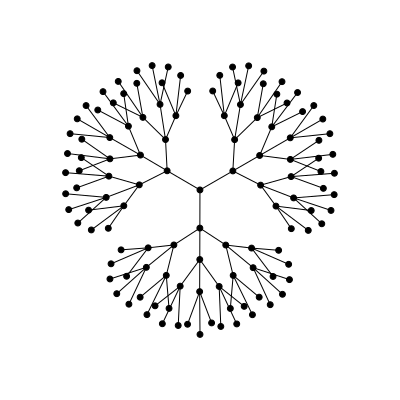

In [191]:
using GraphRecipes
graphplot(gg, size=(400,400), nodeshape=:circle, curves=false, nodecolor=:black)

In [233]:
bp = mpbp(gl)
cb = CB_BP(bp);

In [ ]:
svd_trunc = TruncBond(8)
svd_trunc = TruncThresh(1e-4)
iters, cb = iterate!(bp, maxiter=50; svd_trunc, cb, tol=1e-4)
@show iters
b_bp = beliefs(bp)
m_bp = belief_expectations(bp);

In [ ]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", size=(300,200), label="",
    yaxis=(:log10, (minimum(replace(cb.Δs, 0.0=>Inf)), maximum(cb.Δs))), widen=true)

In [ ]:
bond_dims.(bp.μ)

In [172]:
sms = SoftMarginSampler(bp);

In [ ]:
ns = 5*10^5
sms = sample!(sms, ns);

In [ ]:
b_mc = marginals(sms)
m_mc = [[bbb[1]-bbb[2] for bbb in bb] for bb in b_mc];

In [ ]:
title = @sprintf "Monte Carlo %.0e samples" length(sms.X)
pl_mc = plot(xlabel="time", ylabel="magnetization", xticks=0:5:T, title=title)
for i in 1:N
    y = getproperty.(m_mc[i], :val)
    yerr = getproperty.(m_mc[i], :err)
    plot!(pl_mc, 0:T, y, ribbon=yerr, label="i=$i", m=:o, ms=3, lw=1, markerstrokecolor=:auto)
end
pl_bp = plot(xlabel="time", ylabel="magnetization", xticks=0:5:T, title="MPBP")
for i in 1:N
    plot!(pl_bp, 0:T, m_bp[i], label="i=$i", m=:o, ms=3, lw=1, markerstrokecolor=:auto)
end
r = round( cor(reduce(vcat, m_bp), getproperty.(reduce(vcat, m_mc), :val)), digits=6)
pl_sc = scatter(reduce(vcat, m_bp), reduce(vcat, m_mc), xlabel="MPBP", ylabel="MonteCarlo", 
    label="magnetization", ms=3, c=:black, legend=:outertopright, title="ρ = $r",
    xlims=(-1,1), ylims=(-1,1), widen=true)
plot!(identity, label="", size=(300,300))
typeof(svd_trunc) == TruncBond && println("Max matrix size: ", svd_trunc.mprime, "x", svd_trunc.mprime)
plot(pl_mc, pl_bp, pl_sc, titlefontsize=10, size=(950, 300), legend=:outerbottomright, 
    margin=5Plots.mm, layout=(1,3))

In [ ]:
r_bp = autocorrelations(bp);

In [ ]:
c_bp = autocovariances(bp; r = r_bp, m = b_bp);

In [ ]:
r_mc = autocorrelations(sms);

In [ ]:
c_mc = autocovariances(sms; r = r_mc, m = b_mc);

In [257]:
using ColorSchemes
function plot_autocovs(c, i, T; skip_even=false, title, kw...)
    step = skip_even ? 2 : 1
    ci = c[i]
    us = 2:2:T
    cg = cgrad(:matter, length(us), categorical=true)
    pl = plot(xlabel="\$\\Delta t \$",  
        ylabel="\$\\langle\\sigma_i^t\\sigma_i^{t+\\Delta t}\\rangle-\\langle\\sigma_i^t\\rangle\\langle\\sigma_i^{t+\\Delta t}\\rangle \$", 
            legend=:outertopright, title=title)
     
    for (j,u) in enumerate(us)
        if eltype(ci) <: MatrixProductBP.Measurement
            y = getproperty.(ci[(0:step:u-1) .+ 1,u+1], :val)
            yerr = getproperty.(ci[(0:step:u-1) .+ 1,u+1], :err)
            plot!(pl, u:-step:1, y, label="t+Δt=$u", c=cg[j], m=:o, msc=cg[j], ribbon=yerr; kw...) 
        else
            plot!(pl, u:-step:1, ci[(0:step:u-1) .+ 1,u+1], label="t+Δt=$u", c=cg[j], m=:o, msc=cg[j]; kw...) 
        end
    end
    pl
end  

plot_autocovs (generic function with 1 method)

In [258]:
i = 1
skip_even = true
pl_autocov_mc = plot_autocovs(c_mc, i, T; title = "Monte Carlo - i=$i", skip_even)
pl_autocov_bp = plot_autocovs(c_bp, i, T; title = "MPBP - i=$i", skip_even, legend=false);

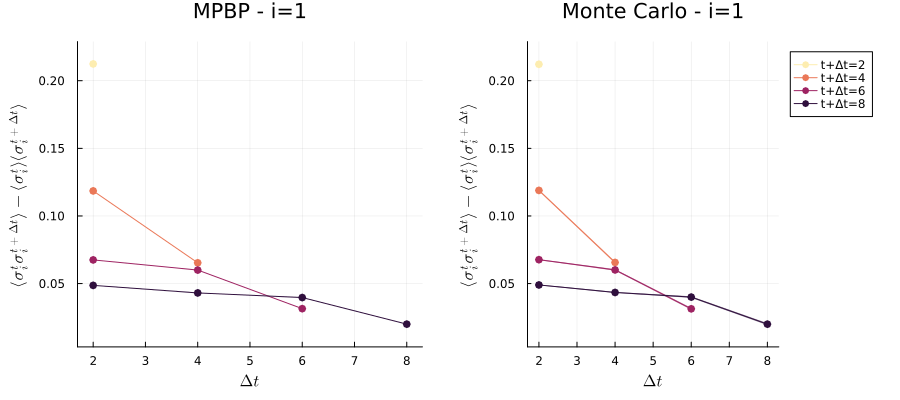

In [259]:
yl = ( min(ylims(pl_autocov_mc)[1], ylims(pl_autocov_bp)[1]), 
        max(ylims(pl_autocov_mc)[2], ylims(pl_autocov_bp)[2]) )
plot(pl_autocov_bp, pl_autocov_mc, size=(900,400), margin=5Plots.mm, ylims=yl, widen=1.1)